In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
from sfp_nsdsyn import utils, sfm
from sfp_nsdsyn.visualization import plot_1D_model_results as vis1D
from pysurfer.mgz_helper import get_vertices_in_labels, read_label, get_existing_labels_only
from pysurfer.freeview_helper import retinotopy_colors

%load_ext autoreload
%autoreload 2

# Configurations

In [2]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
overlay_dir='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn'
fig_dir='/Volumes/server/Projects/sfp_nsd/derivatives/figures'
sn_list = [f'subj{sn:02d}' for sn in np.arange(1,9)]

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

# Load base frequency preference maps

## load in labels for each subject

In [161]:
labels = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'FFA-1','FFA-2','PPA', 'wangVO1', 'wangVO2', 'wangPHC1', 'wangPHC2']
r2thres=0.3
precisionthres=2
val='mode'
ref_frame='absolute'

In [162]:
hemi_rois, hemi_voxels = {}, {}
for sn, hemi in product(sn_list, ['lh','rh']):
    k=f'{sn}-{hemi}'
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    sfp_mgz=os.path.join(output_dir, "sfp_maps", "mgzs", "nsdsyn", f"{hemi}.mask-intersection_r2thres-{r2thres}_precisionthres-{precisionthres}_sub-{sn}_value-{val}_frame-{ref_frame}.mgz")
    hemi_rois[k], hemi_voxels[k] = sfm.extract_roi_values(labels, label_dir, sfp_mgz)

## turn them into one dataframe

In [163]:
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)

In [164]:
all_df_filtered = all_df.query('10**-1 < value < 10**3')

In [165]:

# Define a custom function to determine the value of the new column
def determine_value(row):
    if row['ROI'] in ['V1','V2','V3','hV4']:
        return 'early-retinotopy'
    elif row['ROI'] in ['wangVO1', 'wangVO2', 'wangPHC1','wangPHC2']:
        return 'vo-areas'
    else:
        return 'category-selective'


# Apply the function to the 'ROI' column to create a new column 'NewColumn'
all_df_filtered['roi_type'] = all_df_filtered.apply(lambda row: determine_value(row), axis=1)

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# Distribution of the values

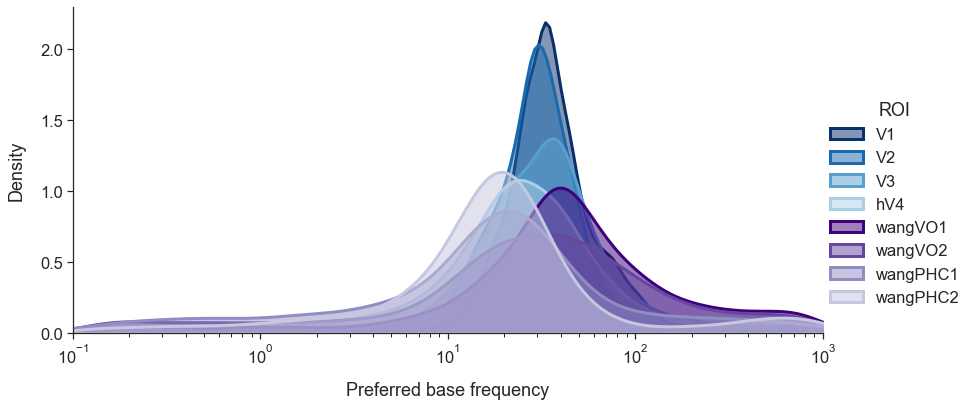

In [166]:
# Plotting the histogram
save_path=os.path.join(fig_dir, "sfp_maps", "mgzs", "nsdsyn", 'quantification', 'base-sfp_preference_histogram_vo.png')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)
roi_list = ['V1','V2','V3','hV4','wangVO1', 'wangVO2','wangPHC1','wangPHC2']
grid = sns.FacetGrid(all_df_filtered,
                     palette=retinotopy_colors(roi_list, to_seaborn=True),
                     height=6, hue='ROI',hue_order=roi_list,
                     aspect=1.9, sharex=True, sharey=True)
grid.set(xlim=(10**-1, 10**3))
for axis in grid.axes.flat:
    axis.tick_params(labelbottom=True)
# g = grid.map(sns.histplot, 'value',
#          bins=100, linewidth=0.8, edgecolor='black', alpha=0.6,
#          element='bars', stat='density', common_norm=False,
#          kde=True, log_scale=(True,False))
g = grid.map(sns.kdeplot, 'value', fill=True, log_scale=(True,False), linewidth=3, alpha=0.5)

grid.set_axis_labels('Preferred base frequency', 'Density')
g.add_legend()
plt.savefig(save_path)



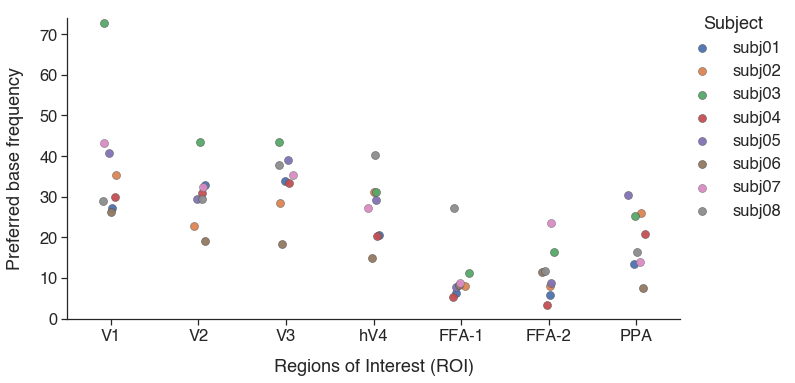

In [167]:
# Calculate median values for each subject and ROI
roi_list=['V1','V2','V3','hV4','FFA-1','FFA-2','PPA']
#roi_list = ['V1','V2','V3','hV4','wangVO1', 'wangVO2','wangPHC1','wangPHC2']
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=2)
save_path=os.path.join(fig_dir, "sfp_maps", "mgzs", "nsdsyn", 'quantification', f"fig-medianplot_mask-intersection_hue-sub_sub-all_value-mode_frame-{ref_frame}.png")
medians = all_df_filtered.groupby(['sub', 'ROI'])['value'].median().reset_index()

grid, g= vis1D.plot_median_for_each_sub_and_roi(medians, 'ROI', 'value', x_order=roi_list,
                                           hue='sub', to_logscale=False,
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5.5, aspect=1.8, ylim=(0,74),
                                           y_label=r"Preferred base frequency",
                                          save_path=save_path)

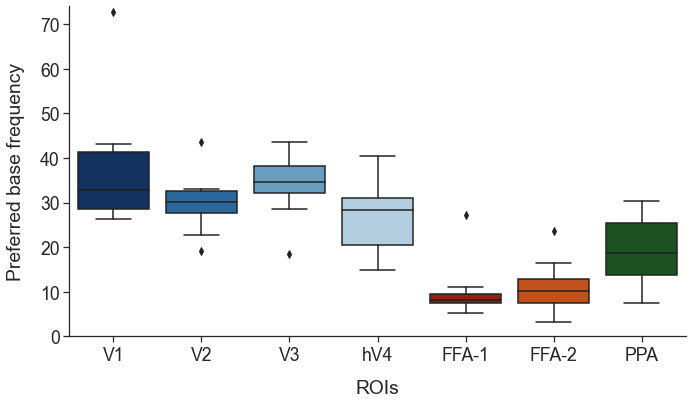

In [168]:
# Set the size of the figure
plt.figure(figsize=(10, 6))  # Adjust the size as needed
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.6)
ax = sns.boxplot(x='ROI', y='value', data=medians, palette=retinotopy_colors(roi_list, to_seaborn=True), order=roi_list)
ax.set_ylabel('Preferred base frequency')
ax.set_xlabel('ROIs')
plt.tight_layout()
ax.set_ylim(0, 74)
ax.set_yticks([0,10,20,30,40,50,60,70])
save_path=os.path.join(fig_dir, "sfp_maps", "mgzs", "nsdsyn", 'quantification', f"fig-boxmedianplot_mask-intersection_hue-sub_sub-all_value-mode_frame-{ref_frame}.png")
plt.savefig(save_path)


In [8]:
all_df = pd.DataFrame({})
for sn in sn_list:
    # Convert the dictionary to a DataFrame
    data_df = pd.DataFrame({key: pd.Series(value) for key, value in lh_rois[sn].items()})
    # Melt the DataFrame to have ROI values in a single column
    melted_data = data_df.melt(var_name='ROI', value_name='base frequency preference')
    melted_data['hemi'] = 'lh'

    data_df = pd.DataFrame({key: pd.Series(value) for key, value in rh_rois[sn].items()})
    # Melt the DataFrame to have ROI values in a single column
    melted_data_2 = data_df.melt(var_name='ROI', value_name='base frequency preference')
    melted_data_2['hemi'] = 'rh'

    tmp = pd.concat((melted_data, melted_data_2), axis=0)
    tmp['sn'] = sn
    all_df = pd.concat((all_df, tmp), axis=0)

In [10]:
# Define a colormap from Matplotlib
cmap = plt.cm.get_cmap('Blues_r')

# Define the number of colors based on the number of ROIs
ret_colors = [cmap(i / 10) for i in range(10)]
colors = []
colors += [ret_colors[0], ret_colors[0], ret_colors[2], ret_colors[2], ret_colors[4], ret_colors[4], ret_colors[6]]
# Define a colormap from Matplotlib
colors += ['magenta', 'magenta']
colors += ['gray']
palette = dict(zip(labels, colors))

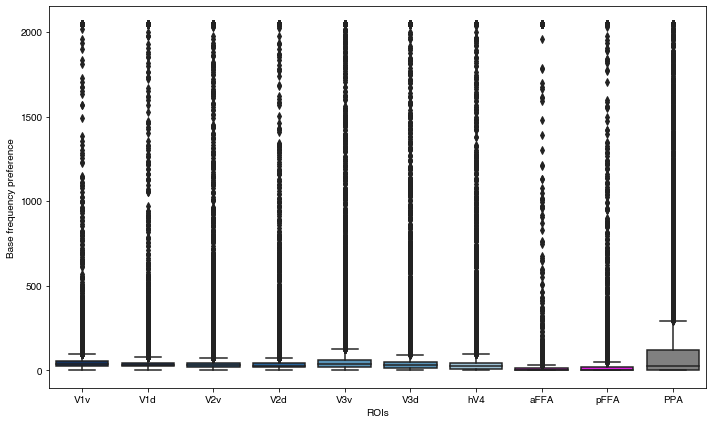

In [11]:
# Set the size of the figure
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='ROI', y='base frequency preference', data=all_df, palette=palette, order=labels)
ax.set_ylabel('Base frequency preference')
#ax.set_ylim(-10, 300)
ax.set_xlabel('ROIs')
plt.tight_layout()

# goodness of fit

In [16]:
lh_rois = {}
rh_rois = {}
my_val = 'r2'
thres=0
ref_frame='absolute'
for sn in sn_list:
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    lh_labels, lh_label_paths = get_existing_labels_only(labels, label_dir, 'lh', return_paths=True)
    rh_labels, rh_label_paths = get_existing_labels_only(labels, label_dir, 'rh', return_paths=True)

    mgz_path = os.path.join(overlay_dir, f'lh.mask-precision_sub-{sn}_value-{my_val}_thres-{thres}_frame-{ref_frame}.mgz')
    lh_rois[sn] = get_vertices_in_labels(mgz_path, lh_label_paths, lh_labels, load_mgz=True, load_label=True)

    mgz_path = os.path.join(overlay_dir, f'rh.sub-{sn}_value-{my_val}.mgz')
    rh_rois[sn] = get_vertices_in_labels(mgz_path, rh_label_paths, rh_labels, load_mgz=True, load_label=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.mask-precision_sub-subj01_value-r2_thres-0_frame-absolute.mgz'

In [83]:
new_df = pd.DataFrame({})
for sn, hemi, roi in product(sn_list, ['lh','rh'], labels):
    tmp = all_df.query('ROI == @roi & hemi == @hemi & sn == @sn')
    all_counts = len(tmp['base frequency preference'])
    if all_counts != 0:
        nan_counts = np.divide(sum(np.isnan(tmp['base frequency preference'])), all_counts)*100
        tmp = pd.DataFrame({'roi': [roi],
                            'sn': [sn],
                            'hemi': [hemi],
                            'nan_percent': [nan_counts]})
        new_df = pd.concat((new_df, tmp), axis=0)


In [90]:
new_df = new_df.groupby(['roi','sn']).mean().reset_index()

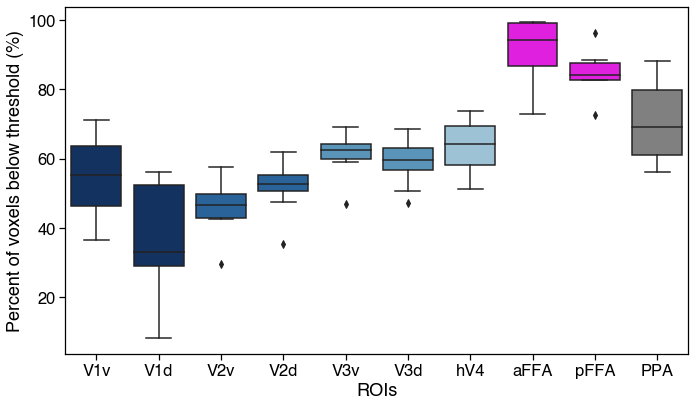

In [93]:
sns.set_context("notebook", font_scale=1.5)

# Set the size of the figure
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='roi', y='nan_percent', data=new_df, palette=palette, order=labels)
ax.set_ylabel('Percent of voxels below threshold (%)')
ax.set_xlabel('ROIs')
plt.tight_layout()

In [ ]:
sns.set_context("notebook")
# Create a figure with subplots



fig, axs = plt.subplots(nrows=1, ncols=len(labels), figsize=(12, 5), sharey=True)
# Use a for loop to create violin plots for each subject
for i, ax in enumerate(axs):
    sns.boxplot(data=all_precisions[i], color=colors[i], ax=ax)
    ax.set_title('Subject {}'.format(i+1))
    ax.set_ylim(-0.05, 8)
    ax.set_xticks([])
    ax.set_xticklabels([])

# Set common ylabel
fig.text(0.08, 0.5, 'Precision values', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Subjects', ha='center', va='center')
fig.suptitle('Distribution of Precision Values for Each Subject', y=1.02)

# Show the plot
utils.save_fig(os.path.join(fig_dir, 'quantification', 'violinplot_sub-all_value-precision.png'))
plt.show()

In [ ]:
# Calculate median values for each subject and ROI
save_path=os.path.join(fig_dir,"sfp_maps", "mgzs", "nsdsyn", f"fig-medianplot_mask-r2_thres-0.2_hue-sub_sub-all_value-mode_frame-{ref_frame}.png")

medians = all_df.groupby(['sub', 'ROI'])['value'].median().reset_index()
roi_list=['V1','V2','V3','hV4','FFA-1','FFA-2','PPA']
g= vis1D.plot_median_for_each_sub_and_roi(medians, 'ROI', 'value', x_order=roi_list,
                                           hue='sub',
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5,
                                           y_label=r"Base frequency preference",
                                           palette=retinotopy_colors(to_seaborn=True),
                                          save_path=save_path)